# **Sentiment Analysis for Product Reviews**

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import math
import warnings
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Set plotting style
sns.set_style("whitegrid")
%matplotlib inline 
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NZHOLDOS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NZHOLDOS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Load the dataset with the correct delimiter
file_path = r"C:\Users\NZHOLDOS\Desktop\Project\Amazon Product Review.txt"
data = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

# Check the columns in the dataset
print("Columns in the dataset:")
print(data.columns)

# Display the first few rows of the dataset 
print(data.head())

Columns in the dataset:
Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')
  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     11555559  R1QXC7AHHJBQ3O  B00IKPX4GY         2693241   
1          US     31469372  R175VSRV6ZETOP  B00IKPYKWG         2693241   
2          US     26843895  R2HRFF78MWGY19  B00IKPW0UA         2693241   
3          US     19844868   R8Q39WPKYVSTX  B00LCHSHMS         2693241   
4          US      1189852  R3RL4C8YP2ZCJL  B00IKPZ5V6         2693241   

                           product_title product_category  star_rating  \
0  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            5   
1  Fire HD 7, 7" HD Display, Wi-Fi, 8 GB               PC            3   
2  Fire 

In [6]:
data.dropna(subset=['review_headline', 'review_body'], inplace=True)

# Function to clean text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()                   # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['cleaned_review_headline'] = data['review_headline'].apply(clean_text)
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

# Clean extra spaces
data['cleaned_review_headline'] = data['cleaned_review_headline'].str.replace(r'\s+', ' ', regex=True).str.strip()
data['cleaned_review_body'] = data['cleaned_review_body'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Verify the new columns
print("Cleaned Review Headline and Body:")
print(data[['cleaned_review_headline', 'cleaned_review_body']].head())

Cleaned Review Headline and Body:
                             cleaned_review_headline  \
0                                         five stars   
1  lots ads slow processing speed occasionally sh...   
2                                well thought device   
3  appsgames looking forward using compatible tab...   
4                                         five stars   

                                 cleaned_review_body  
0                                         great love  
1  lots adsslow processing speedoccasionally shut...  
2  excellent unit versatility tablet besides comp...  
3  bought amazon prime ended buying gb one camera...  
4         amazon products continue meet expectations  


In [7]:
# Function to label sentiment based on star ratings
def label_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'negative'
    elif star_rating == 3:
        return 'neutral'
    elif star_rating in [4, 5]:
        return 'positive'
    else:
        return 'unknown'  

# Apply the function to the 'star_rating' column
data['sentiment_label'] = data['star_rating'].apply(label_sentiment)

# Verify the new column
print("Sentiment labels based on star ratings:")
print(data[['star_rating', 'sentiment_label']].head())

Sentiment labels based on star ratings:
   star_rating sentiment_label
0            5        positive
1            3         neutral
2            5        positive
3            4        positive
4            5        positive


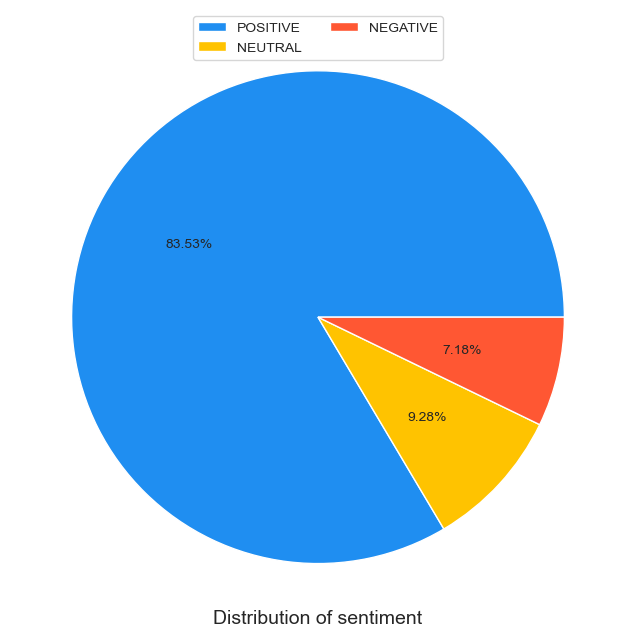

In [9]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
colors = ['#1F8EF1', '#FFC300', '#FF5733']
plt.pie(data['sentiment_label'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

<Figure size 1600x700 with 0 Axes>

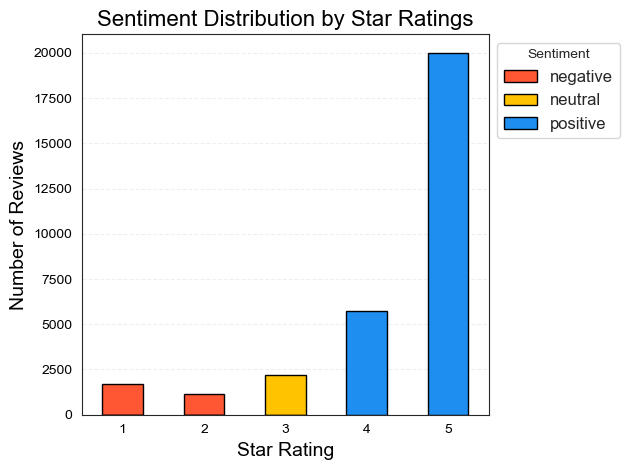

In [11]:
# 1. Sentiment Distribution by Star Ratings
sns.set_style("white")

# Count the sentiment labels for each star rating
sentiment_counts_by_rating = data.groupby('star_rating')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment by star ratings
plt.figure(figsize=(16, 7))
sentiment_counts_by_rating.plot(kind='bar', 
                              stacked=True, 
                              color=['#FF5733', '#FFC300', '#1F8EF1'], 
                              edgecolor='black')

# plot styling 
plt.title('Sentiment Distribution by Star Ratings', fontsize=16, color='black')
plt.xlabel('Star Rating', fontsize=14, color='black')
plt.ylabel('Number of Reviews', fontsize=14, color='black')
plt.xticks(rotation=0, color='black')
plt.yticks(color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Sentiment', 
          fontsize=12, 
          bbox_to_anchor=(1, 1), 
          loc='upper left', 
          frameon=True)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

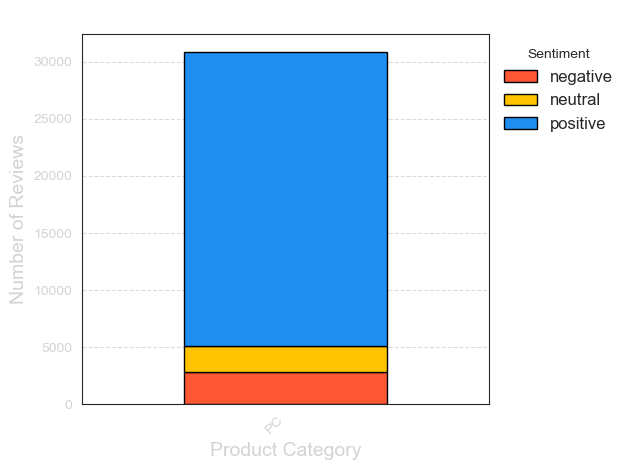

In [12]:
# 2. Sentiment Distribution by Product Categories

plt.figure(figsize=(18, 8))  
sentiment_counts_by_category = data.groupby('product_category')['sentiment_label'].value_counts().unstack().fillna(0)

# Plot the distribution of sentiment across product categories
sentiment_counts_by_category.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#1F8EF1'], edgecolor='black')
plt.title('Sentiment Distribution by Product Categories', fontsize=16, color='white')
plt.xlabel('Product Category', fontsize=14, color='lightgray')
plt.ylabel('Number of Reviews', fontsize=14, color='lightgray')
plt.xticks(rotation=45, ha='right', color='lightgray')
plt.yticks(color='lightgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

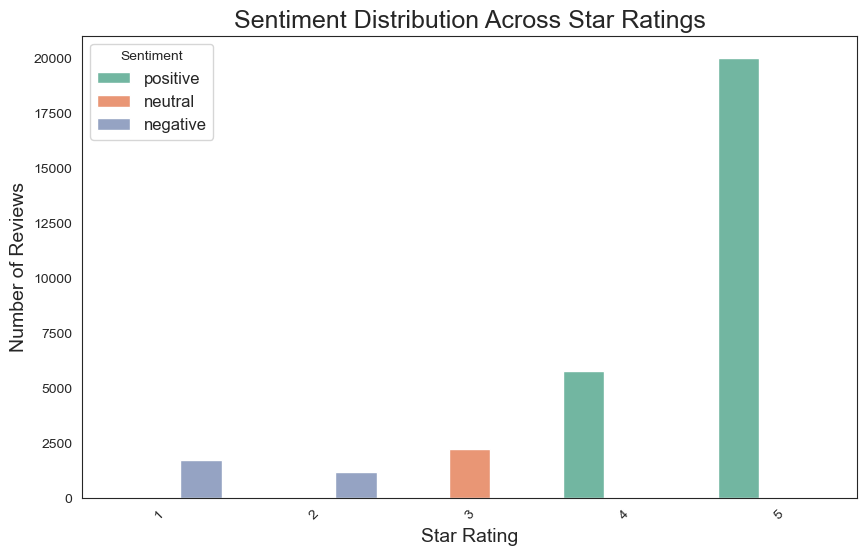

In [13]:
# 3. Star Rating Distribution by Sentiment
# Count plot for sentiment distribution across star ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='star_rating', hue='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution Across Star Ratings', fontsize=18)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show()

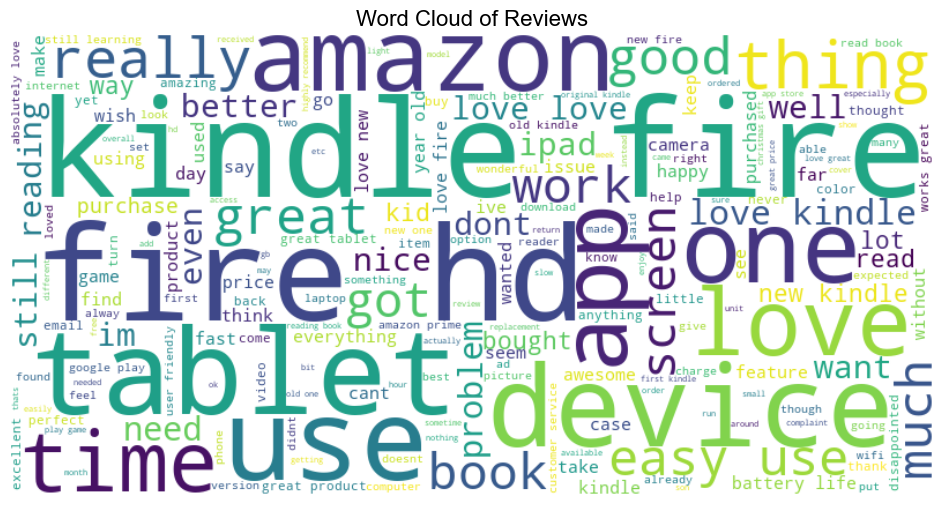

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 4. Perform Basic Text Analysis - Word Cloud
# Combine all cleaned reviews into a single string
all_reviews = ' '.join(data['cleaned_review_body'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',  
    colormap='viridis',       
    contour_color='black',    
    contour_width=1,
    random_state=42          
).generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Reviews', fontsize=16, color='black')  
plt.show()

In [15]:
# Function to clean text data
def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.lower()                   # Convert to lowercase
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply the clean_text function to 'review_body'
data['cleaned_review_body'] = data['review_body'].apply(clean_text)

In [16]:
# Initialise the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  

# Fit and transform the cleaned review body
X = vectorizer.fit_transform(data['cleaned_review_body'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the shape of the TF-IDF 
print("Shape of TF-IDF matrix:", X.shape)
print("First few features:\n", tfidf_df.head())

Shape of TF-IDF matrix: (30846, 5000)
First few features:
    abc  abilities  ability  able  absolute  absolutely  abundance  abuse  \
0  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
1  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
2  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
3  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   
4  0.0        0.0      0.0   0.0       0.0         0.0        0.0    0.0   

   abysmal   ac  ...  youre  youtube  youtubecom  youve   yr  yrs  zero  \
0      0.0  0.0  ...    0.0      0.0         0.0    0.0  0.0  0.0   0.0   
1      0.0  0.0  ...    0.0      0.0         0.0    0.0  0.0  0.0   0.0   
2      0.0  0.0  ...    0.0      0.0         0.0    0.0  0.0  0.0   0.0   
3      0.0  0.0  ...    0.0      0.0         0.0    0.0  0.0  0.0   0.0   
4      0.0  0.0  ...    0.0      0.0         0.0    0.0  0.0  0.0   0.0   

   zinio   zombies  zoom  
0    0

In [17]:
# Prepare the Data

X = vectorizer.fit_transform(data['cleaned_review_body'])
y = data['sentiment']  

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Train the Logistic Regression Model

# Initialise the logistic regression model
model = LogisticRegression(max_iter=1000)  

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
# Make Predictions

y_pred = model.predict(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.90
Precision: 0.89
Recall: 0.90
F1 Score: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65      1018
           1       0.92      0.97      0.94      5152

    accuracy                           0.90      6170
   macro avg       0.84      0.76      0.79      6170
weighted avg       0.89      0.90      0.89      6170



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


Training Logistic Regression...

Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65      1018
           1       0.92      0.97      0.94      5152

    accuracy                           0.90      6170
   macro avg       0.84      0.76      0.79      6170
weighted avg       0.89      0.90      0.89      6170


Training Random Forest...

Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.43      0.56      1018
           1       0.90      0.98      0.94      5152

    accuracy                           0.89      6170
   macro avg       0.85      0.71      0.75      6170
weighted avg       0.88      0.89      0.87      6170


Training SVM...

Model: SVM
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1018
           1       0.92      

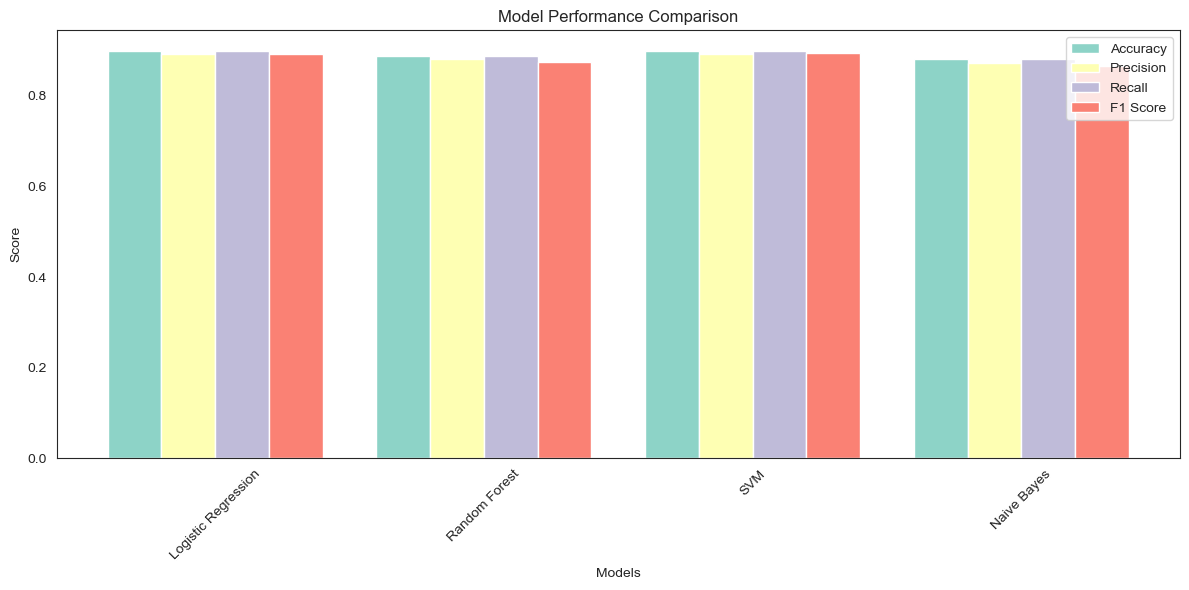


Best performing model: SVM with F1 Score: 0.8945


In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": LinearSVC(random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Dictionary to store results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    results['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))
    
    print(f"\nModel: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bar_width = 0.2
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, 
           results_df[metric], 
           width=bar_width, 
           label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + bar_width * 1.5, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Find best model
best_model_name = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
best_score = results_df['F1 Score'].max()
print(f"\nBest performing model: {best_model_name} with F1 Score: {best_score:.4f}")

In [27]:
# Save best model
best_model = models[best_model_name]
joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']